# <font color = 'VFFKIOOLATEE'>Airbnb New User Bookings

<img src='https://imgur.com/JsHyyRl.png'>
ref: https://imgur.com/JsHyyRl

### <font color = 'GREWWG'>Problem statement :

In order to lease or rent short-term lodging, including vacation rentals, apartment rentals, homestays, hostel beds, or hotel rooms, customers can use Airbnb, an online marketplace and hospitality business. On Airbnb, new users can reserve a room in more than 34,000 cities in 190+ countries. In order to share more individualised content with their community, shorten the average time to first booking, and more precisely predict demand, Airbnb must be able to reliably predict where a new user will book their first vacation experience. Based on his tailored content, a new user's initial vacation destination needs to be predicted.

### <font color = 'GREEEN'>Data Overview:

## <font color = 'GREWWG'>Reference links:
* https://en.wikipedia.org/wiki/Airbnb
* https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview
* https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview/evaluation
* https://github.com/jnikhilreddy/Airbnb-new-user-bookings/blob/master/0.Exploratory_Data_Analysis.ipynb
* https://github.com/DAYA7624/Airbnb-New-User-Bookings
* https://github.com/RenXiangyuan/Kaggle-Airbnb-Recruit
* https://gist.github.com/HarshalPal/652a5ef92a4570959ee8b151cf3d4483
* https://medium.com/@pal.harshal


* **Train_users.csv -** There are 16 features used to describe each user in the dataset:
    * id: user id
    * date_account_created: the date of account creation
    * timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_creat date_first_booking 
    * date_first_booking: date of first booking
    * gender
    * age
    * signup_method
    * signup_flow: the page a user came to signup up from
    * language: international language preference
    * affiliate_channel: what kind of paid marketing
    * affiliate_provider: where the marketing is e.g. google, craigslist, other
    * first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
    * signup_app
    * first_device_type
    * first_browser
    * country_destination: this is the target variable you are to predict
    
* **Sessions.csv -** web sessions log for users
    * user_id: to be joined with the column 'id' in users table
    * action
    * action_type
    * action_detail
    * device_type
    * secs_elapsed

* **Countries.csv -** summary statistics of destination countries in this dataset and their locations

* **Age_gender_bkts.csv -** summary statistics of users' age group, gender, country of destination

## <font color = 'GREWWG'>Objective:

 * Predict top **5 travel destinations** in decreasing order of relevance
 
## <font color = 'GREWWG'>Performance metrics:

 * The Performance metric used for this Project is **NDCG (Normalized discounted cumulative gain)**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
# import all required modules
import pandas as pd
import numpy as np
import missingno as ms
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
import colorama
from colorama import Fore
import matplotlib.gridspec as gridspec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from scipy.sparse import hstack
import pickle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer
import matplotlib.gridspec as gridspec
from prettytable import PrettyTable
from tqdm import tqdm
# Importing all the models 
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [16]:
# read sessions data from csv file
session = pd.read_csv("/content/gdrive/MyDrive/Case_studies/sessions.csv")
print(Fore.RED +"Session_Data shape:",session.shape)
print("\nColumns:",session.columns)
session.head(6)

Session_Data shape: (10567737, 6)

Columns: Index(['user_id', 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed'],
      dtype='object')


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0


In [17]:
# read Train data from csv file
train=pd.read_csv("/content/gdrive/MyDrive/Case_studies/train_users_2.csv")
print(Fore.RED +"Train shape:",train.shape)
print("\nColumns:",train.columns)

# replace all -unknown- by Nan
train.gender.replace('-unknown-',np.nan, inplace=True)
train.age.replace('NaN', np.nan, inplace=True)
train.head(6)

Train shape: (213451, 16)

Columns: Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,NaN,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US


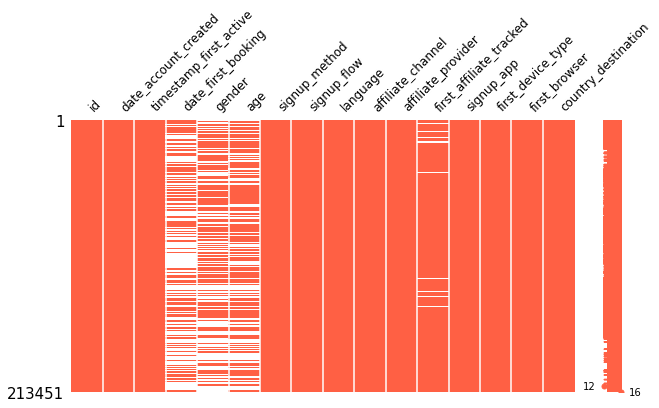

In [6]:
ms.matrix(train, figsize=(10,5), fontsize=12, color=(1, 0.38, 0.27))

* <font color = 'RED'> Missingno plot for Train Data show that there is a lot of missing values in gender, age.

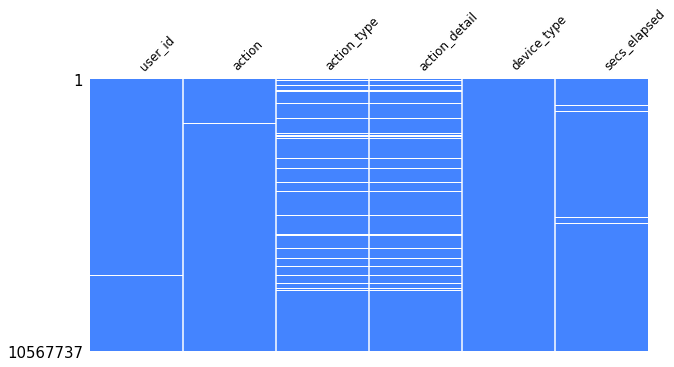

In [7]:
ms.matrix(session, sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0))

* <font color = 'RED'> Missingno plot for Session Data show that there is few missing value in the data when compared to Train data

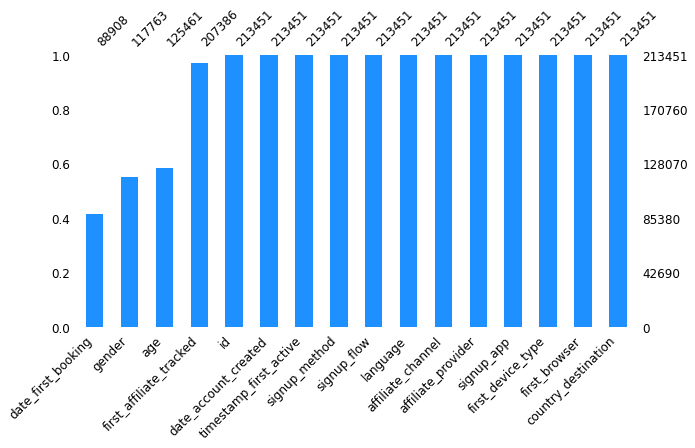

In [8]:
ms.bar(train, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12)

### <font color='green'>UNIVARIATE ANALYSIS</font>

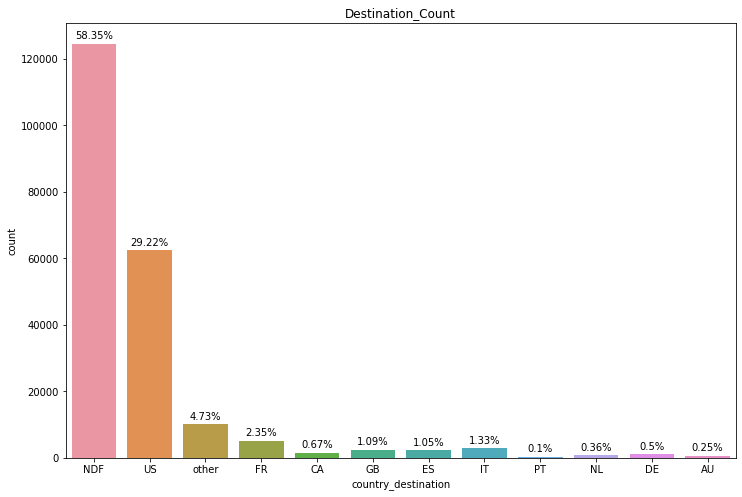

-----------------
 Percentage_Count
-----------------
NDF      58.347349
US       29.222632
other     4.728954
FR        2.353233
IT        1.328174
GB        1.088774
ES        1.053638
CA        0.669006
DE        0.497070
NL        0.356991
AU        0.252517
PT        0.101663
Name: country_destination, dtype: float64


In [86]:
# ref: https://seaborn.pydata.org/generated/seaborn.countplot.html
# Country_destination feature analysis
plt.figure(figsize=(12,8))
count=sns.countplot(train["country_destination"])
dist_sum=sum([patch.get_height() for patch in  count.patches])
for patch in count.patches:
    count.annotate("{}%".format(np.round((patch.get_height()/dist_sum)*100,2)), (patch.get_x() + patch.get_width() / 2., patch.get_height()),size=10,
                    xytext = (0, 8), textcoords ='offset points', ha='center', va='center')
plt.title("Destination_Count")
plt.show()
print(Fore.BLUE +"-----------------")
print(Fore.RED +" Percentage_Count")
print(Fore.BLUE +"-----------------")
print(train.country_destination.value_counts() / train.shape[0] * 100)

1. <font color = 'RED'> As shown from above, NDF (No Destination Found) has the largest number of class labels (~58%) followed by US (~29%) and others (~5%).</font>
2. <font color = 'RED'>NDF stands for website visitors who did not make a purchase. The majority of users are those who registered but haven't made any trip arrangements.</font>
3. <font color = 'RED'>However, the majority of customers favour US travel over NDF.</font>
4. <font color = 'RED'>Few individuals make the decision to go to other places.

In [23]:
# Removing 'Non_Bookings' or NDF rows
train1 = train[train['country_destination']!='NDF']

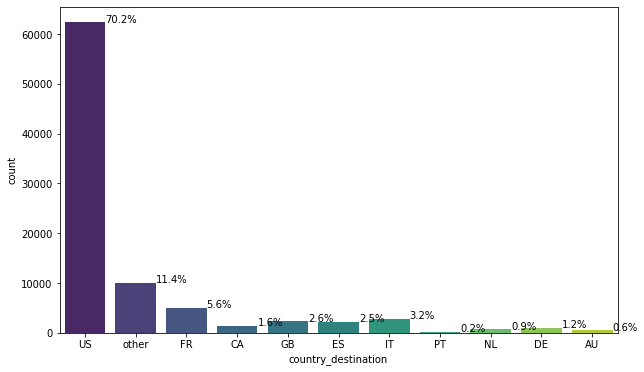

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="country_destination", data=train1, palette = "viridis")

for p in ax.patches:
    percentage = f'{np.round((100 * p.get_height()/train1.shape[0]), 1)}%'
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y))

1. <font color = 'RED'>We can observe that the US has roughly 70% of the trip bookings after eliminating the NDF class designation.</font>
2. <font color = 'RED'>11% of people visited nations not included in the class description, according to the data.

In [25]:
# ref: https://www.geeksforgeeks.org/numpy-percentile-in-python/
# Obtaining secs_elasped and sort to compute percentile
sec_percentile =session["secs_elapsed"].values
sec_percentile = np.sort(sec_percentile,axis = None)

#computing secs_elasped values at each percntile 90,91,92,93,94,95,96,97,98,99,100
print(Fore.BLUE +"-"*30)
for i in range(90,100):
    print(Fore.RED +"{} percentile value is {}".format(i,sec_percentile[int(len(sec_percentile)*(float(i)/100))]))
print("100 percentile value is ",sec_percentile[-1])
print(Fore.BLUE +"-"*30)


#computing secs_elasped values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
print(Fore.BLUE +"-"*28)
for i in np.arange(0.0, 1.0, 0.1):
    print(Fore.RED +"{} percentile value is {}".format(99+i,sec_percentile[int(len(sec_percentile)*(float(99+i)/100))]))
print("100 percentile value is ",sec_percentile[-1])
print(Fore.BLUE +"-"*28)


#computing secs_elasped values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
print(Fore.BLUE +"-"*28)
for i in range(0,100,10):
    print(Fore.RED +"{} percentile value is {}".format(i,sec_percentile[int(len(sec_percentile)*(float(i)/100))]))
print("100 percentile value is ",sec_percentile[-1])
print(Fore.BLUE +"-"*30)

------------------------------
90 percentile value is 39789.0
91 percentile value is 45479.0
92 percentile value is 52703.0
93 percentile value is 62191.0
94 percentile value is 75591.0
95 percentile value is 95600.0
96 percentile value is 129705.0
97 percentile value is 202165.0
98 percentile value is 457827.0
99 percentile value is nan
100 percentile value is  nan
------------------------------
----------------------------
99.0 percentile value is nan
99.1 percentile value is nan
99.2 percentile value is nan
99.3 percentile value is nan
99.4 percentile value is nan
99.5 percentile value is nan
99.6 percentile value is nan
99.7 percentile value is nan
99.8 percentile value is nan
99.9 percentile value is nan
100 percentile value is  nan
----------------------------
----------------------------
0 percentile value is 0.0
10 percentile value is 52.0
20 percentile value is 144.0
30 percentile value is 383.0
40 percentile value is 712.0
50 percentile value is 1188.0
60 percentile value is 

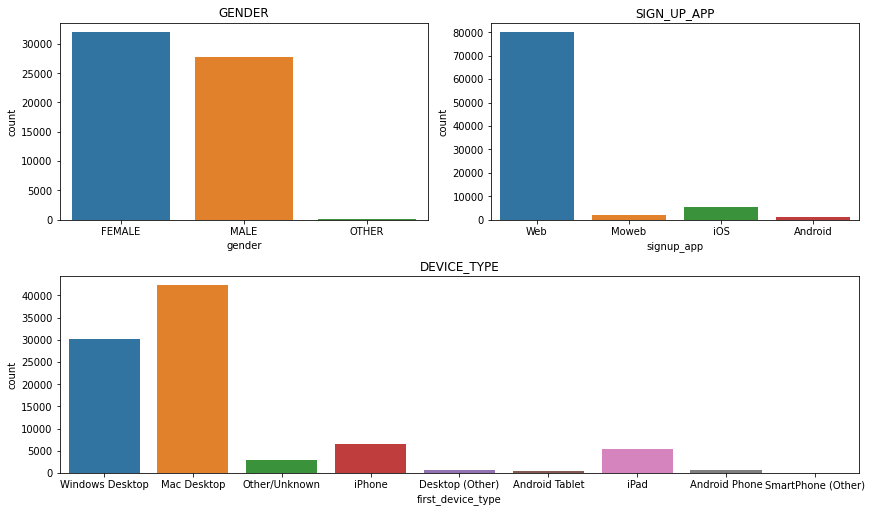

--------------------------------------------------
First_device_type_Percentage_Count
--------------------------------------------------
Mac Desktop           100.778333
Windows Desktop        81.787916
iPhone                 23.348855
iPad                   16.127907
Other/Unknown          11.997795
Android Phone           3.152697
Android Tablet          1.453188
Desktop (Other)         1.348585
SmartPhone (Other)      0.085482
Name: first_device_type, dtype: float64
--------------------------------------------------
Gender_Percentage_Count
--------------------------------------------------
FEMALE    70.905880
MALE      61.231835
OTHER      0.317182
Name: gender, dtype: float64
--------------------------------------------------
signup_app_Percentage_Count
--------------------------------------------------
Web        205.512440
iOS         21.391776
Moweb        7.042111
Android      6.134431
Name: signup_app, dtype: float64


In [32]:
# ref: https://matplotlib.org/3.2.1/tutorials/intermediate/gridspec.html
# Gender feature analysis
fig1 = plt.figure(constrained_layout=True,figsize = (12,7))
gs = fig1.add_gridspec(4, 4)
f1_ax1 = fig1.add_subplot(gs[0:2,0:2])
sns.countplot(train1["gender"],)
plt.title("GENDER")

# signup_app feature analysis
f1_ax2 = fig1.add_subplot(gs[0:2, 2:])
sns.countplot(train1["signup_app"])
plt.title("SIGN_UP_APP")

# first_device_type feature analysis
f1_ax3 = fig1.add_subplot(gs[2:, 0:])
sns.countplot(train1["first_device_type"])
plt.title("DEVICE_TYPE")
plt.show()

print(Fore.BLUE +"-"*50)
print(Fore.RED +"First_device_type_Percentage_Count")
print(Fore.BLUE +"-" * 50)
print(train.first_device_type.value_counts() / train1.shape[0] * 100)

print(Fore.BLUE +"-"*50)
print(Fore.RED +"Gender_Percentage_Count")
print(Fore.BLUE +"-" * 50)
print(train.gender.value_counts() / train1.shape[0] * 100)

print(Fore.BLUE +"-"*50)
print(Fore.RED +"signup_app_Percentage_Count")
print(Fore.BLUE +"-" *50)
print((train.signup_app.value_counts() / train1.shape[0] * 100).head(5))

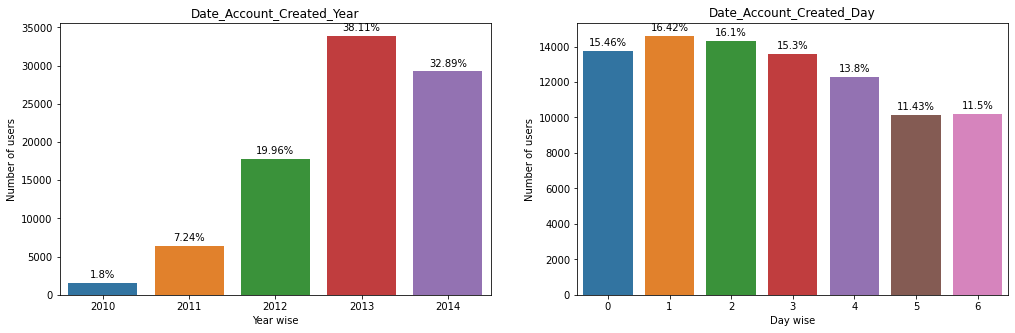

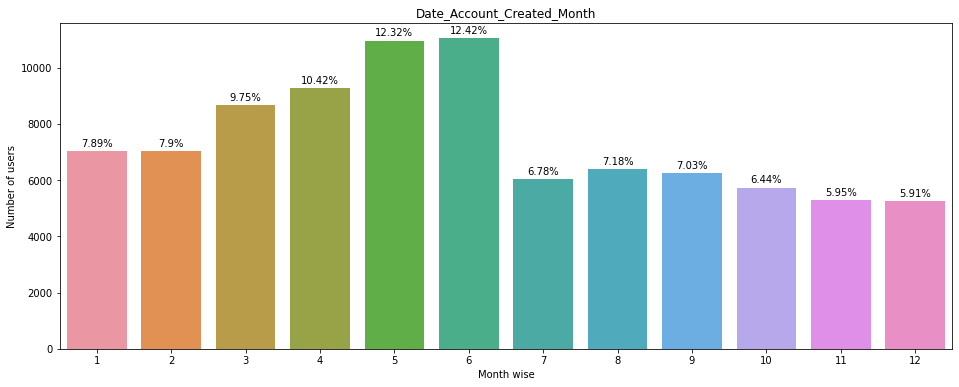

In [36]:
# ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
# obtaining info of year, month and day by Converting Str to date-time.
time_stamp = pd.DataFrame()
time_stamp['date_account_created_new'] = pd.to_datetime(train1['date_account_created'])
time_stamp['date_account_created_day'] = time_stamp.date_account_created_new.dt.weekday
time_stamp['date_account_created_month'] = time_stamp.date_account_created_new.dt.month
time_stamp['date_account_created_year'] = time_stamp.date_account_created_new.dt.year

plt.figure(1,figsize=(17, 5))
# Date_account_created analysis by year
plt.subplot(121)            
count=sns.countplot(x='date_account_created_year',data=time_stamp)
dist_sum=sum([patch.get_height() for patch in  count.patches])
for patch in count.patches:
    count.annotate("{}%".format(np.round((patch.get_height()/dist_sum)*100,2)), (patch.get_x() + patch.get_width() / 2., patch.get_height()),size=10,
                    xytext = (0, 8), textcoords ='offset points', ha='center', va='center')
plt.xlabel('Year wise')
plt.ylabel('Number of users')
plt.title("Date_Account_Created_Year")

# Date_account_created analysis by weekday               
plt.subplot(122)
sns.set_palette("tab10")
count = sns.countplot(x='date_account_created_day',data=time_stamp)
dist_sum = sum([patch.get_height() for patch in  count.patches])
for patch in count.patches:
    count.annotate("{}%".format(np.round((patch.get_height()/dist_sum)*100,2)), (patch.get_x() + patch.get_width() / 2., patch.get_height()),size=10,
                    xytext = (0, 8), textcoords ='offset points', ha='center', va='center')
plt.xlabel('Day wise')
plt.ylabel('Number of users')
plt.title("Date_Account_Created_Day")


# Date_account_created analysis by month
plt.figure(2,figsize=(16, 6))
plt.subplot(111)               
count=sns.countplot(x='date_account_created_month',data=time_stamp)
dist_sum=sum([patch.get_height() for patch in  count.patches])
for patch in count.patches:
    count.annotate("{}%".format(np.round((patch.get_height()/dist_sum)*100,2)), (patch.get_x() + patch.get_width() / 2., patch.get_height()),size=10,
                    xytext = (0, 8), textcoords ='offset points', ha='center', va='center')
plt.title("Date_Account_Created_Month")
plt.ylabel('Number of users')
plt.xlabel('Month wise')
plt.show()

1. <font color = 'RED'>Saturday and Sunday had the lowest weekly account creation rates, with June having the highest monthly account creation rates.</font>
2. <font color = 'RED'>The number of users increases linearly with time.

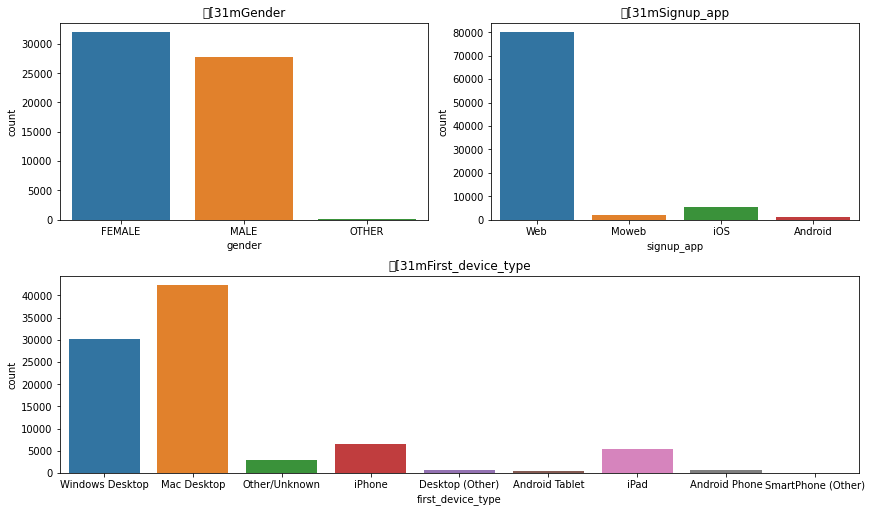

--------------------------------------------------
Gender_Percentage_Count
--------------------------------------------------
FEMALE    35.984388
MALE      31.179421
OTHER      0.197957
Name: gender, dtype: float64
--------------------------------------------------
signup_app_Percentage_Count
--------------------------------------------------
Web        90.004274
iOS         6.198542
Moweb       2.410357
Android     1.386827
Name: signup_app, dtype: float64
--------------------------------------------------
First_device_type_Percentage_Count
--------------------------------------------------
Mac Desktop           47.521033
Windows Desktop       33.913709
iPhone                 7.217573
iPad                   6.145679
Other/Unknown          3.233680
Android Phone          0.804202
Desktop (Other)        0.618617
Android Tablet         0.517389
SmartPhone (Other)     0.028119
Name: first_device_type, dtype: float64


In [37]:
# ref: https://matplotlib.org/3.2.1/tutorials/intermediate/gridspec.html


# Gender feature analysis
fig1 = plt.figure(constrained_layout=True,figsize=(12,7))
gs = fig1.add_gridspec(4, 4)
f1_ax1 = fig1.add_subplot(gs[0:2,0:2])
sns.countplot(train1["gender"],)
plt.title("Gender")

# signup_app feature analysis
f1_ax2 = fig1.add_subplot(gs[0:2, 2:])
sns.countplot(train1["signup_app"])
plt.title("Signup_app")


# first_device_type feature analysis
f1_ax3 = fig1.add_subplot(gs[2:, 0:])
sns.countplot(train1["first_device_type"])
plt.title("First_device_type")
plt.show()

print(Fore.BLUE +"-" * 50)
print(Fore.RED +"Gender_Percentage_Count")
print(Fore.BLUE +"-" * 50)
print(train1.gender.value_counts() / train1.shape[0] * 100)

print(Fore.BLUE +"-" * 50)
print(Fore.RED +"signup_app_Percentage_Count")
print(Fore.BLUE +"-" * 50)
print((train1.signup_app.value_counts() / train1.shape[0] * 100).head(5))

print(Fore.BLUE +"-" * 50)
print(Fore.RED +"First_device_type_Percentage_Count")
print(Fore.BLUE +"-" * 50)
print(train1.first_device_type.value_counts() / train1.shape[0] * 100)

1. <font color = 'RED'>More **Female** users than male users are registered, and **34%** of users do not know their gender.</font>
2. <font color = 'RED'>For booking, the majority of consumers utilise **Desktops** as their first device.</font>
3. <font color = 'RED'>Users frequently utilise **Websites** as sign-up forms.</font>

In [40]:
# checking for distribution of age
print(f"Minimum documented age: {min(train1['age'].values)}")
print(f"Maximum documented age: {max(train1['age'].values)}")

Minimum documented age: 2.0
Maximum documented age: 2014.0


<font color = 'RED'>In theory, no one can be as old as 2014. Since this data was compiled across multiple years, including 2014, it is likely that a user misinterpreted the information and mistook his or her age with the present year. 

We view 2014 as an anomaly; in fact, we may view any age more than 100 as an anomaly.</font>

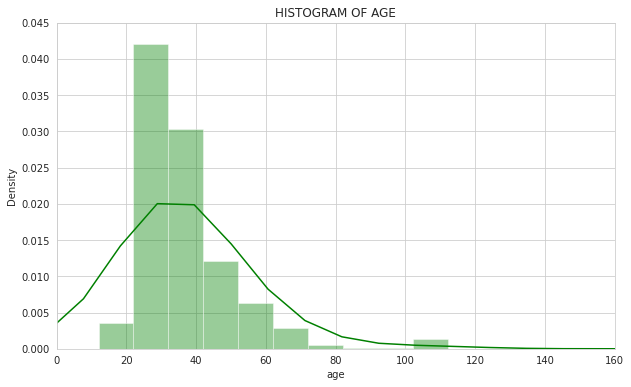

In [ ]:
# Probability Density Function
sns.set_style("whitegrid")
plt.figure(figsize = (10,6))
sns.distplot(train1['age'], bins = 201,color="g")
plt.title("HISTOGRAM OF AGE")
plt.ylabel("Density")
xmin, xmax, ymin, ymax = plt.axis([ 0, 160, 0, 0.045])
plt.show()

1. <font color = 'RED'> According to our data, the maximum age is 2014. We consider any age of that kind to be an anomaly since it is most likely a mistake caused by a user's misperception.</font>

2. <font color = 'RED'>We thus set our top and lower age limits at 100 and 18, respectively.</font>

(18.0, 100.0)

<Figure size 1440x720 with 0 Axes>

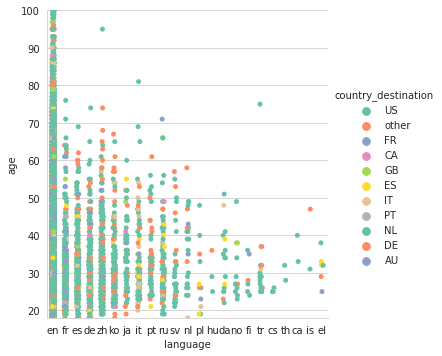

<Figure size 1440x720 with 0 Axes>

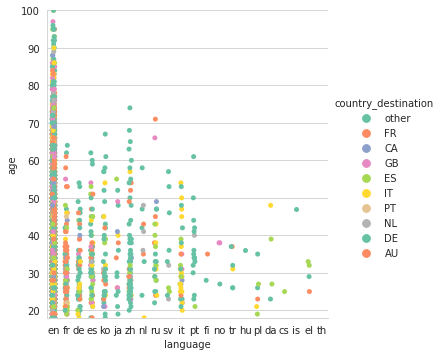

In [ ]:
plt.figure(figsize = (20,10))
sns.catplot(x = "language", y = "age", data = train1,hue = 'country_destination',palette = 'Set2')
plt.ylim(18,100)
sns.despine()

train2 = train1[train1['country_destination']!='US']

plt.figure(figsize = (20,10))
sns.catplot(x = "language", y = "age", data = train2,hue='country_destination',palette='Set2')
plt.ylim(18,100)

* <font color = 'RED'> In the first plot, we see that English-speaking individuals go to all locations, with the majority of them going to the United States and being between the ages of 20 and 70.</font>
* <font color = 'RED'>People speaking English have varying ages in the second plot after the US class designation has been removed.</font>
* <font color = 'RED'>People that speak "zh" are often younger and travel to other countries. They range in age from 22 to 40.</font>

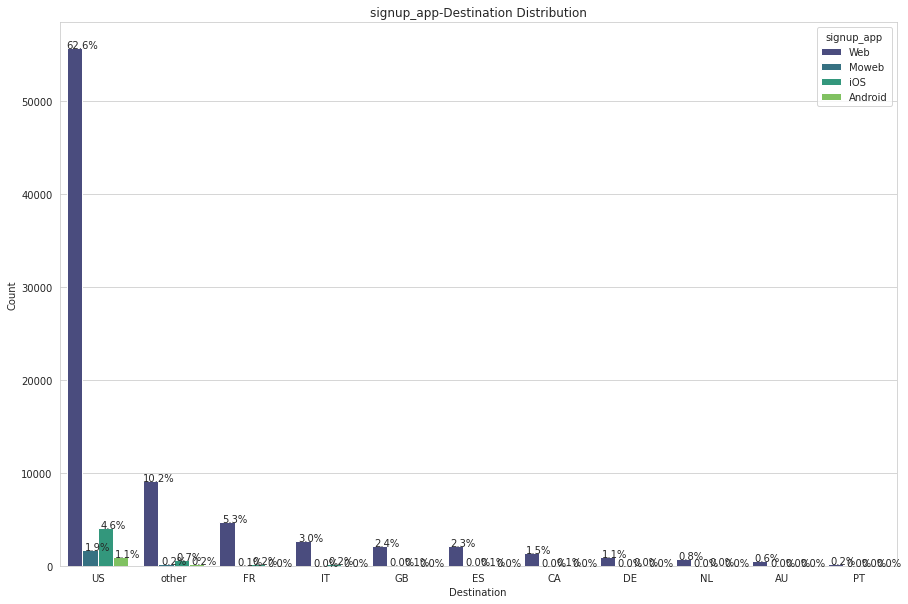

In [ ]:
# Bar plot for signup_app
plt.figure(figsize = (15,10))
ax = sns.countplot(data = train1, x = 'country_destination', order = train1['country_destination'].value_counts().index , hue='signup_app',palette = "viridis")
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('signup_app-Destination Distribution')
total = float(len(train1))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')

Text(0.5, 0, 'signup_app')

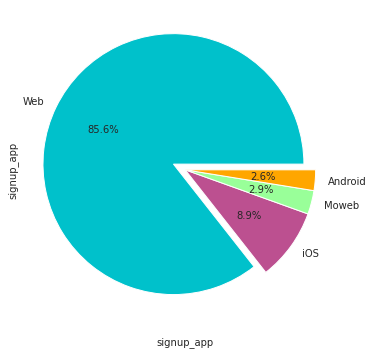

In [ ]:
# pie chart for signup_app
colors = ['#00C1CB','#BC5090','#99ff99','#FFA600']
explode = (0.1, 0, 0, 0)
sns.set_style("darkgrid")
plt.figure(figsize=(6,6))
percentage = train['signup_app'].value_counts() / train.shape[0] * 100
percentage.plot(kind='pie', explode=explode ,autopct="%1.1f%%", colors=colors)
plt.xlabel('signup_app')

1. <font color = 'RED'>From the first plot, 62% of those travelling to the US signed up online.</font>
2. <font color = 'RED'>According to the first plot, just around 9% of users use iOS as their sign-up method, while only about 85% of users choose the web. Android and moweb have relatively low percentages.</font>
3. <font color = 'RED'>The majority of iOS users travel to the US.</font>

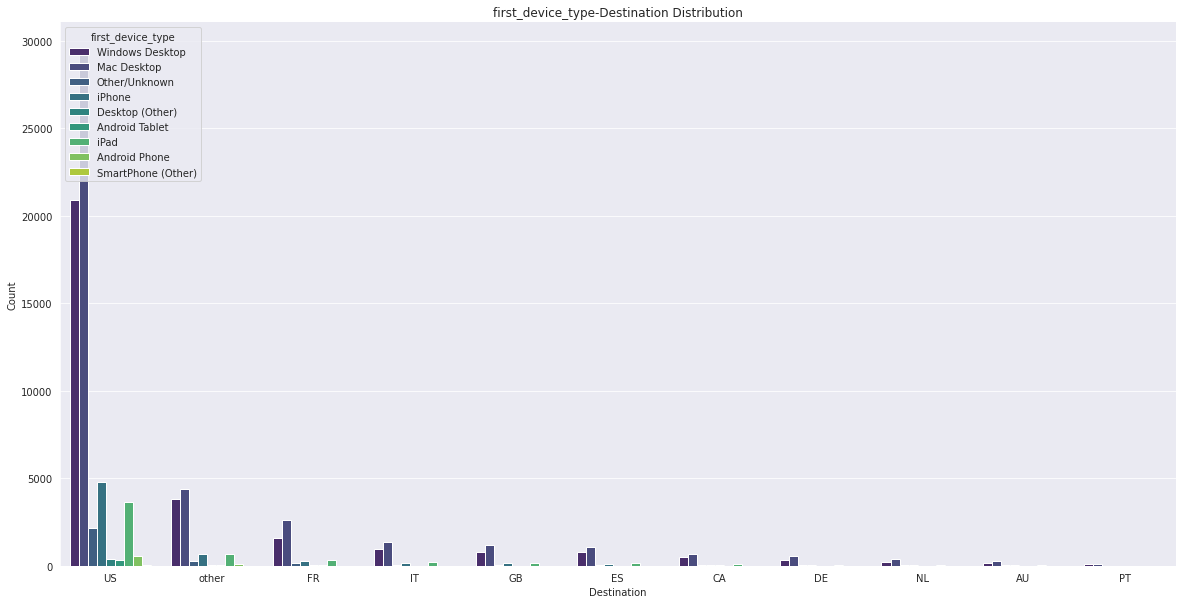

In [ ]:
plt.figure(figsize=(20,10))
ax=sns.countplot(data = train1, x = 'country_destination', order = train1['country_destination'].value_counts().index , hue='first_device_type',palette = "viridis")
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('first_device_type-Destination Distribution')
sns.despine()

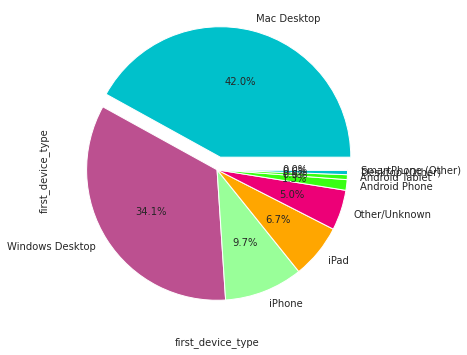

In [ ]:
colors = ['#00C1CB','#BC5090','#99ff99','#FFA600','#ED0077','#38FF13','#38FF13']
explode = (0.1, 0, 0, 0,0,0,0,0,0)
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
percentage = train['first_device_type'].value_counts() / train.shape[0] * 100
percentage.plot(kind='pie', explode = explode ,autopct="%1.1f%%", colors=colors)
plt.xlabel('first_device_type')
sns.despine()

1. <font color = 'RED'>The majority of people who come to the US use Windows desktops as their initial device type, followed by Mac desktops.</font>
2. <font color = 'RED'>A person who uses an iPhone or iPad will also be travelling mostly to the US.</font>
3. <font color = 'RED'>Aside from the US and other countries, none of the iPhone users go to other nations such as IT, CA, etc.</font>

In [42]:
# Splitting date-time data for temporal features: 'date account created' and 'date_first_booking'
# here, 4 columns have been added, making total cols = 20
train1['account_created_day'] = pd.DatetimeIndex(train1['date_account_created']).day
train1['account_created_month'] = pd.DatetimeIndex(train1['date_account_created']).month
train1['first_booking_day'] = pd.DatetimeIndex(train1['date_first_booking']).day
train1['first_booking_month'] = pd.DatetimeIndex(train1['date_first_booking']).month
train1.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,first_booking_day,first_booking_month
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,28,9,2,8
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,5,12,8,9


Text(0.5, 1.0, 'Boxplot between country_destination and account_created_month')

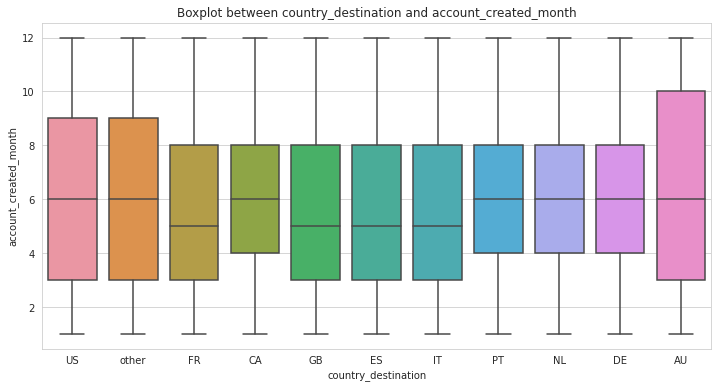

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x = train1['country_destination'], y = train1['account_created_month'])
plt.title('Boxplot between country_destination and account_created_month')

Text(0.5, 1.0, 'Boxplot between country_destination and account_created_month')

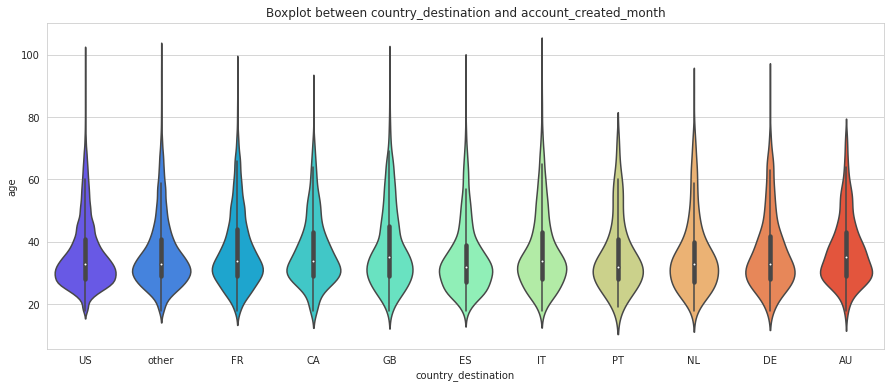

In [ ]:
#Boxplot between country_destination and age

train1.loc[train1.age<18]=np.nan
train1.loc[train1.age>100]=np.nan

plt.figure(figsize=(15,6))
sns.violinplot(data=train1 , y='age', x='country_destination',palette='rainbow')
plt.title('Boxplot between country_destination and account_created_month')

1. <font color = 'RED'> Around midyear, the majority of tourists created their accounts.</font>
2. <font color = 'RED'>US and other-bound travellers created their accounts second and third most frequently after most visitors headed to Australia.</font>
3. <font color = 'RED'>The shortest time of the year was when the majority of visitors to places like CA, PT, NL, and DE created their accounts.</font>

### <font color = 'GREWWG'>BIVARIATE ANALYSIS

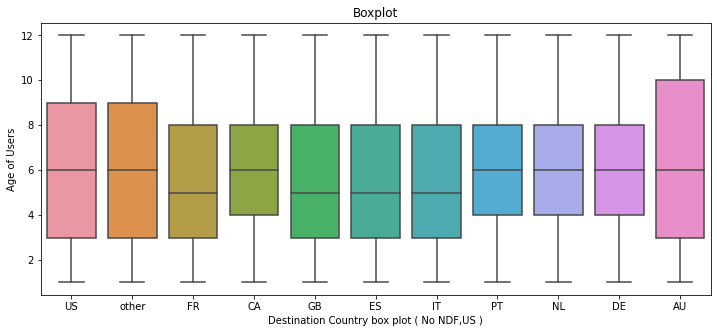

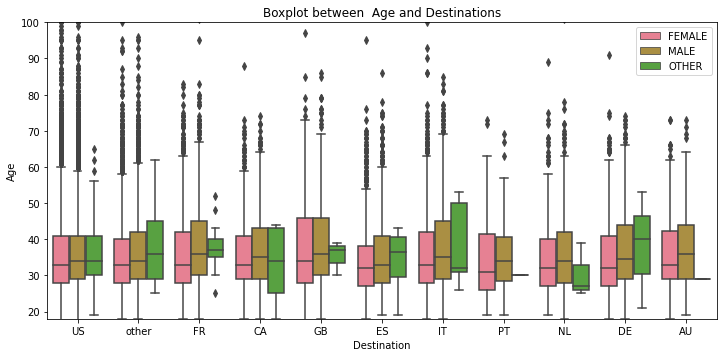

In [44]:
# ref: https://seaborn.pydata.org/generated/seaborn.boxplot.html
# Box_plot analysis on country_destination by Age Feature

plt.figure(1,figsize=(12, 5))  
plt.subplot(111)            
sns.boxplot(x = train1['country_destination'], y = train1['account_created_month'])
sns.set_palette("husl")
plt.ylabel('Age of Users')
plt.title("Boxplot")
plt.xlabel('Destination Country box plot ( No NDF,US )')
plt.show()

#Box-plot btwn Age and Destination

plt.figure(2,figsize=(12, 12))               
plt.subplot(211)   
sns.boxplot(x = train1['country_destination'], y = train1['age'], hue = train1['gender'])
plt.ylabel('Age')
plt.title('Boxplot between  Age and Destinations')
plt.xlabel('Destination')
plt.ylim(18,100)
plt.legend(loc=1)

<font color = 'blue'>Bivariate observations include:

* <font color = 'RED'>More older travellers than any other demographic visit the country destination "Great Britain." </font>
* <font color = 'RED'>Spain is the country destination with the highest percentage of **Younger** travellers.</font>
* <font color = 'RED'>Compared to other countries, **Australia** has very no users of the gender Other.</font>
* <font color = 'RED'>To continue **Explore Data**, Multivate analysis is required.</font>

Text(0.5, 1.0, 'Age,First Device Type and Country')

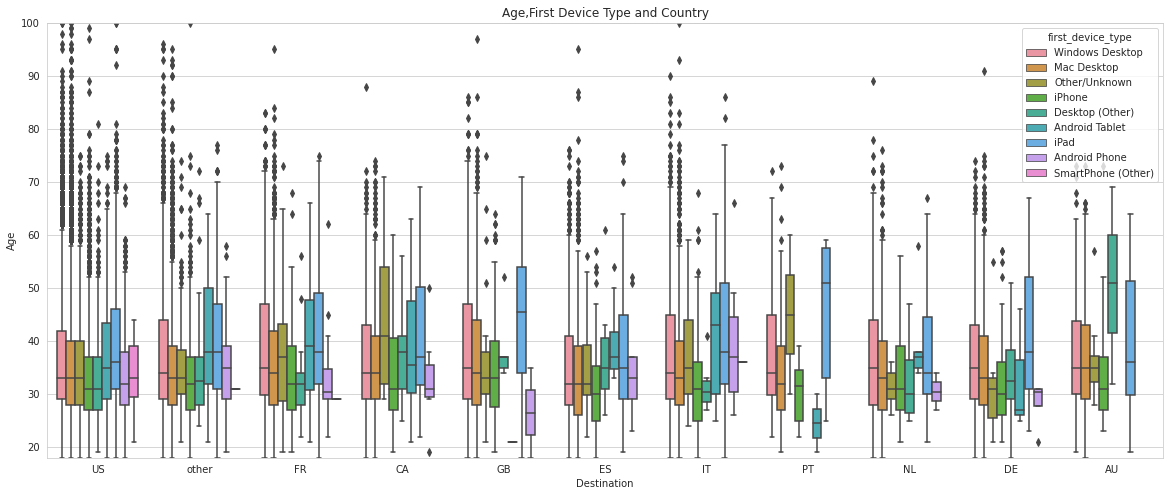

In [ ]:
# Box-plot between Age-Destination

plt.figure(figsize=(20,8))
sns.boxplot(x = train1['country_destination'], y = train1['age'], hue = train1['first_device_type'])
plt.ylim(18,100)
plt.xlabel('Destination')
plt.ylabel('Age')
plt.title('Age,First Device Type and Country')

1. <font color = 'RED'> Windows-powered desktops dominate the interests of international travellers.</font>
2. <font color = 'RED'>The iPad is well-liked by people of all ages across all destination categories.</font>
3. <font color = 'RED'>Android phones were the most popular gadget among visitors going to NL, but least popular among those going to PT and AU.</font>
4. <font color = 'RED'>Younger travellers, particularly those under 40, used iPhones more often.</font>
5. <font color = 'RED'>Younger travellers, excluding those travelling to Australia, favoured desktops running operating systems other than Windows or Mac.</font>
6. <font color = 'RED'>Only travellers travelling to the US utilised non-Android/non-iOS cellphones.</font>

In [ ]:
train1['first_device_type'].value_counts()

Mac Desktop           41592
Windows Desktop       29671
iPhone                 6354
iPad                   5376
Other/Unknown          2851
Android Phone           708
Desktop (Other)         540
Android Tablet          448
SmartPhone (Other)       25
Name: first_device_type, dtype: int64

### <font color = 'GREWWG'>DATA CLEANING IN TRAIN DATA

In [59]:
# Reading the raw train-data

train = pd.read_csv('/content/gdrive/MyDrive/Case_studies/train_users_2.csv')
print(train.shape)
train.head()

(213451, 16)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [60]:
# Splitting date time data for date account created and date_first_booking
# here, we simply create 4 more columns, each containing date's day, date's month, booking date's day and booking date's month, respectively.

train['account_created_day'] = pd.DatetimeIndex(train['date_account_created']).day
train['account_created_month'] = pd.DatetimeIndex(train['date_account_created']).month
train['first_booking_day'] = pd.DatetimeIndex(train['date_first_booking']).day
train['first_booking_month'] = pd.DatetimeIndex(train['date_first_booking']).month
train.tail(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,first_booking_day,first_booking_month
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,30,6,NaN,NaN
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,30,6,NaN,NaN


In [61]:
# renaming a column

train.rename(columns={"id": "user_id"}, inplace='True')
train.head(2)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,first_booking_day,first_booking_month
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,28,6,NaN,NaN
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,25,5,NaN,NaN


In [63]:
# checking for gender-values

train['gender'].value_counts()

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

In [64]:
# cleaning the train data variables, performing some basic punctuatuon marks removal

train['first_device_type'] = [ s.replace(' ', "_") for s in train.first_device_type]
train['affiliate_channel'] = [ s.replace('-', "_") for s in train.affiliate_channel]
train['affiliate_provider'] = [ s.replace('-', "_") for s in train.affiliate_provider]
train['first_device_type'] = [ s.replace('/', "_") for s in train.first_device_type]
train['first_device_type'] = [ s.replace('(', "") for s in train.first_device_type]
train['first_device_type'] = [ s.replace(')', "") for s in train.first_device_type]
train['first_browser'] = [ s.replace('-', "") for s in train.first_browser]
train['first_browser'] = [ s.replace(' ', "_") for s in train.first_browser]
train['first_browser'] = [ s.replace('.', "_") for s in train.first_browser]
train['gender'] = [ s.replace('-', "") for s in train.gender]
train.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,first_booking_day,first_booking_month
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,unknown,NaN,facebook,0,en,direct,direct,untracked,Web,Mac_Desktop,Chrome,NDF,28,6,NaN,NaN
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac_Desktop,Chrome,NDF,25,5,NaN,NaN
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows_Desktop,IE,US,28,9,2.0,8.0
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac_Desktop,Firefox,other,5,12,8.0,9.0
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,unknown,41.0,basic,0,en,direct,direct,untracked,Web,Mac_Desktop,Chrome,US,14,9,18.0,2.0


In [65]:
# dropping columns 

train = train.drop(['date_account_created', 'timestamp_first_active','date_first_booking','first_affiliate_tracked'], axis=1)
train.head()

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,first_booking_day,first_booking_month
0,gxn3p5htnn,unknown,NaN,facebook,0,en,direct,direct,Web,Mac_Desktop,Chrome,NDF,28,6,NaN,NaN
1,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,Web,Mac_Desktop,Chrome,NDF,25,5,NaN,NaN
2,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,Web,Windows_Desktop,IE,US,28,9,2.0,8.0
3,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,Web,Mac_Desktop,Firefox,other,5,12,8.0,9.0
4,87mebub9p4,unknown,41.0,basic,0,en,direct,direct,Web,Mac_Desktop,Chrome,US,14,9,18.0,2.0


In [66]:
#performing inner join on train and new_session data to form our newer data which we use for feature engineering and modeling

new_train = train.set_index('user_id').join(new_session.set_index('user_id'),how='inner',on='user_id').reset_index()
new_train.head()

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,first_booking_day,first_booking_month,secs_elapsed,action,action_detail,action_type
0,d1mm9tcy42,MALE,62.0,basic,0,en,sem_non_brand,google,Web,Windows_Desktop,Chrome,other,1,1,4.0,1.0,185.000000,header_userpic header_userpic create,header_userpic header_userpic create_user,data data submit
1,yo8nz8bqcq,unknown,NaN,basic,0,en,direct,direct,Web,Mac_Desktop,Firefox,NDF,1,1,NaN,NaN,1019.000000,header_userpic impressions create,header_userpic p4 create_user,data view submit
2,4grx6yxeby,unknown,NaN,basic,0,en,sem_brand,google,Web,Windows_Desktop,Firefox,NDF,1,1,NaN,NaN,4586.205128,show personalize show ajax_refresh_subtota...,p3 wishlist_content_update view_search_resu...,view data view click data data view vi...
3,ncf87guaf0,unknown,NaN,basic,0,en,direct,direct,Web,Windows_Desktop,Chrome,NDF,1,1,NaN,NaN,109896.551724,personalize similar_listings ajax_refresh_s...,wishlist_content_update similar_listings ch...,data data click view view data message_...
4,4rvqpxoh3h,unknown,NaN,basic,25,en,direct,direct,iOS,iPhone,unknown,GB,1,1,2.0,1.0,22369.867470,similar_listings_v2 search_results search_r...,view_search_results view_search_results vie...,view click click click click click clic...


In [67]:
# checking for missing values in 'first_booking_day' column

new_train['first_booking_day'].isnull().values.any()

True

In [68]:
# handling null values in first_booking_day and first_booking_month with 'replacement-with-zero'

new_train['first_booking_day'].fillna(0, inplace=True)
new_train['first_booking_month'].fillna(0,inplace=True)

In [69]:
# cleaning the age field in new_data
# filtering out ages more than 95 years 
# filtering out ages less than 16 years 
# replacing NaN values in 'age' column with it's median

new_train.loc[new_train['age'] > 95, 'age'] = np.nan  
new_train.loc[new_train['age'] < 16, 'age'] = np.nan  
new_train.loc[new_train['age'].isnull(), 'age' ] = new_train['age'].median()    

In [70]:
new_train.head()

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,first_booking_day,first_booking_month,secs_elapsed,action,action_detail,action_type
0,d1mm9tcy42,MALE,62.0,basic,0,en,sem_non_brand,google,Web,Windows_Desktop,Chrome,other,1,1,4.0,1.0,185.000000,header_userpic header_userpic create,header_userpic header_userpic create_user,data data submit
1,yo8nz8bqcq,unknown,32.0,basic,0,en,direct,direct,Web,Mac_Desktop,Firefox,NDF,1,1,0.0,0.0,1019.000000,header_userpic impressions create,header_userpic p4 create_user,data view submit
2,4grx6yxeby,unknown,32.0,basic,0,en,sem_brand,google,Web,Windows_Desktop,Firefox,NDF,1,1,0.0,0.0,4586.205128,show personalize show ajax_refresh_subtota...,p3 wishlist_content_update view_search_resu...,view data view click data data view vi...
3,ncf87guaf0,unknown,32.0,basic,0,en,direct,direct,Web,Windows_Desktop,Chrome,NDF,1,1,0.0,0.0,109896.551724,personalize similar_listings ajax_refresh_s...,wishlist_content_update similar_listings ch...,data data click view view data message_...
4,4rvqpxoh3h,unknown,32.0,basic,25,en,direct,direct,iOS,iPhone,unknown,GB,1,1,2.0,1.0,22369.867470,similar_listings_v2 search_results search_r...,view_search_results view_search_results vie...,view click click click click click clic...


In [71]:
new_train.shape

(73815, 20)

In [72]:
new_train.isna().any()

user_id                  False
gender                   False
age                      False
signup_method            False
signup_flow              False
language                 False
affiliate_channel        False
affiliate_provider       False
signup_app               False
first_device_type        False
first_browser            False
country_destination      False
account_created_day      False
account_created_month    False
first_booking_day        False
first_booking_month      False
secs_elapsed             False
action                   False
action_detail            False
action_type              False
dtype: bool

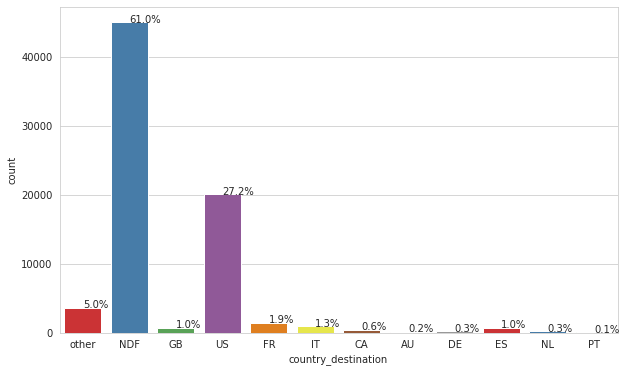

In [ ]:
# Bar plot on country_destination after performing join of two data frames

plt.figure(figsize=(10,6))
ax = sns.countplot(x="country_destination", data=new_train,palette='Set1')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/new_train.shape[0])
    x = p.get_x() + (p.get_width())/2
    y = p.get_height()
    ax.annotate(percentage, (x, y))

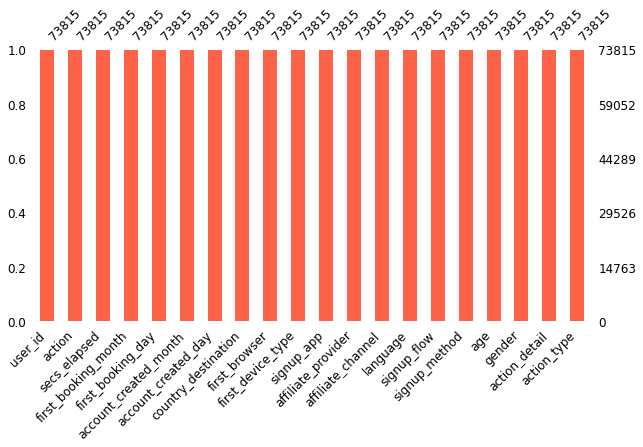

In [73]:
import missingno as miss
miss.bar(new_train, color="tomato", sort="ascending", figsize=(10,5), fontsize=12)

In [ ]:
# saving cleaned data to disk

new_train.to_csv('final_train.csv',  index=False)

<font color = 'RED'>Currently, the train data is NaN-free. The train data has also been tidied up. The engineering of features, encoding, etc., may now be done.

###<font color = 'GREWWG'>DATA CLEANING IN SESSION DATA

In [46]:
session.isna().any()

user_id           True
action            True
action_type       True
action_detail     True
device_type      False
secs_elapsed      True
dtype: bool

In [47]:
print(session.shape)
session.head()

(10567737, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [48]:
#Handing the NaN values: replacing/imputing with mode of column
# column user_id will be dealt later

session['action'].fillna(session['action'].mode()[0], inplace=True)
session['action_type'].fillna(session['action_type'].mode()[0], inplace=True)
session['action_detail'].fillna(session['action_detail'].mode()[0], inplace=True)
session['device_type'].fillna(session['device_type'].mode()[0], inplace=True)
session['secs_elapsed'].fillna(0, inplace=True)

#replacing space with _ in device_type
session.device_type = session.device_type.str.replace(' ',"_")

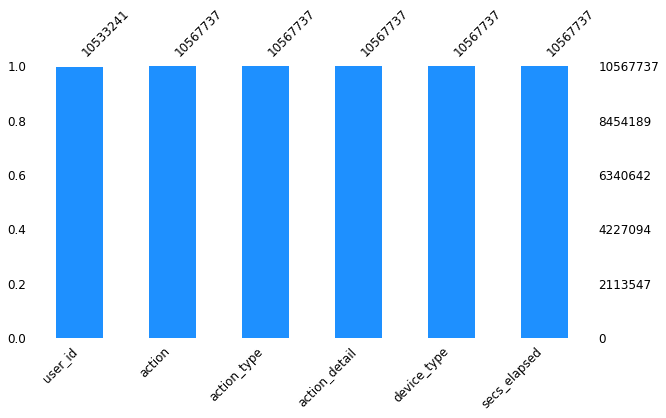

In [50]:
import missingno as miss
miss.bar(session, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12)

user_id          False
action           False
action_type      False
action_detail    False
device_type      False
secs_elapsed     False
dtype: bool


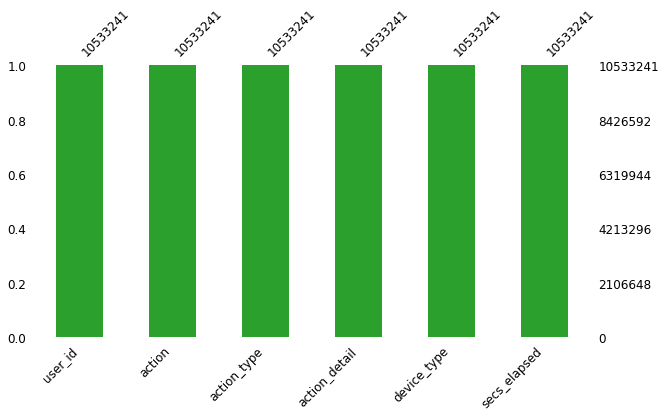

In [58]:
print(session.isna().any())
miss.bar(session, color="tab:green", sort="ascending", figsize=(10,5), fontsize=12)

In [52]:
#Removing null values form user_id

session = session[pd.isnull(session.user_id) == False]

In [53]:
# getting unique user_ids

user_id = list(set(session['user_id'].values))
len(user_id)

135483

In [54]:
#adding spaces to variable to merge in one row 

session['action']   = [" "+i+" " for i in session['action']]
session['action_type']   = [" "+i+" " for i in session['action_type']]
session['action_detail']   = [" "+i+" " for i in session['action_detail']]

In [55]:
# Taking average time spent on website by each user 

sec_e= session.groupby('user_id', sort = False)[['secs_elapsed']].mean()

In [56]:
action = session.groupby('user_id', sort = False)[['action']].sum()
action_type = session.groupby('user_id', sort = False)[['action_type']].sum()
action_detail = session.groupby('user_id', sort = False)[['action_detail']].sum()

In [57]:
# Create new data frame as new_session after using groupby on session data

new_session = pd.DataFrame(user_id,columns=['user_id'])
new_session['secs_elapsed']=sec_e['secs_elapsed'].values
new_session['action'] = action['action'].values
new_session['action_detail']=action_detail['action_detail'].values
new_session['action_type']=action_type['action_type'].values
new_session.head()

,user_id,secs_elapsed,action,action_detail,action_type
0,vtdlub92ea,26988.417323,lookup search_results lookup search_result...,view_search_results view_search_results vie...,view click view click view click view ...
1,amj7yomhtl,23093.555556,dashboard create confirm_email show show_...,dashboard create_user confirm_email_link p...,view submit click view data view data ...
2,vqybeomcyo,70965.250000,verify create show pending requested hea...,-unknown- create_user message_post pending...,-unknown- submit message_post booking_requ...
3,pkmg19ktxt,24704.605263,lookup show search_results search_results ...,view_search_results p3 view_search_results ...,view view click click view view click ...
4,4me9qrz6av,319.375000,campaigns active create notifications lis...,-unknown- -unknown- -unknown- -unknown- -...,-unknown- -unknown- -unknown- -unknown- -...


### <font color = 'GREWWG'> DATA CLEANING IN TEST DATA

In [74]:
data = pd.read_csv('/content/gdrive/MyDrive/Case_studies/test_users.csv')
data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [75]:
# Splitting date time data for date account created and date_first_booking
# here, we simply create 4 more columns, each containing date's day, date's month, booking date's day and booking date's month, respectively.
data['first_booking_day'] = pd.DatetimeIndex(data['date_first_booking']).day
data['first_booking_month'] = pd.DatetimeIndex(data['date_first_booking']).month
data['account_created_day'] = pd.DatetimeIndex(data['date_account_created']).day
data['account_created_month'] = pd.DatetimeIndex(data['date_account_created']).month
data.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,first_booking_day,first_booking_month,account_created_day,account_created_month
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,NaN,NaN,1,7
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,NaN,NaN,1,7


In [76]:
# renaming column

data.rename(columns={"id": "user_id"},inplace='True')
data.head(2)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,first_booking_day,first_booking_month,account_created_day,account_created_month
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,NaN,NaN,1,7
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,NaN,NaN,1,7


In [80]:
test.shape

(61668, 19)

In [81]:
test.columns

Index(['user_id', 'gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'signup_app',
       'first_device_type', 'first_browser', 'first_booking_day',
       'first_booking_month', 'account_created_day', 'account_created_month',
       'secs_elapsed', 'action', 'action_detail', 'action_type'],
      dtype='object')

In [82]:
# filtering the age field in new_data to remove outliers
test.loc[test['age'] < 16, 'age'] = np.nan
test.loc[test['age'] > 95, 'age'] = np.nan
test.loc[test['age'].isnull(), 'age' ] = new_train['age'].median()

In [83]:
# handling null values in first_booking_day and first_booking_month with 'replacement-with-zero'

test['first_booking_day'].fillna(0, inplace=True)
test['first_booking_month'].fillna(0,inplace=True)

In [84]:
test.isna().any()

user_id                  False
gender                   False
age                      False
signup_method            False
signup_flow              False
language                 False
affiliate_channel        False
affiliate_provider       False
signup_app               False
first_device_type        False
first_browser            False
first_booking_day        False
first_booking_month      False
account_created_day      False
account_created_month    False
secs_elapsed             False
action                   False
action_detail            False
action_type              False
dtype: bool

In [77]:
# cleaning punctuation marks
data['affiliate_channel'] = [ s.replace('-', "_") for s in data.affiliate_channel]
data['affiliate_provider'] = [ s.replace('-', "_") for s in data.affiliate_provider]
data['first_device_type'] = [ s.replace(' ', "_") for s in data.first_device_type]
data['first_device_type'] = [ s.replace('/', "_") for s in data.first_device_type]
data['first_browser'] = [ s.replace('.', "_") for s in data.first_browser]
data['first_device_type'] = [ s.replace(')', "") for s in data.first_device_type]
data['first_device_type'] = [ s.replace('(', "") for s in data.first_device_type]
data['first_browser'] = [ s.replace(' ', "_") for s in data.first_browser]
data['first_browser'] = [ s.replace('-', "") for s in data.first_browser]
data['gender'] = [ s.replace('-', "") for s in data.gender]
data.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,first_booking_day,first_booking_month,account_created_day,account_created_month
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile_Safari,NaN,NaN,1,7
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,unknown,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile_Safari,NaN,NaN,1,7
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,unknown,NaN,basic,0,en,direct,direct,linked,Web,Windows_Desktop,Chrome,NaN,NaN,1,7
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,unknown,NaN,basic,0,en,direct,direct,linked,Web,Windows_Desktop,IE,NaN,NaN,1,7
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,unknown,NaN,basic,0,en,direct,direct,untracked,Web,Mac_Desktop,Safari,NaN,NaN,1,7


In [78]:
# dropping unnecessary columns 

data = data.drop(['date_account_created', 'timestamp_first_active','date_first_booking','first_affiliate_tracked'], axis=1)
data.head()

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,first_booking_day,first_booking_month,account_created_day,account_created_month
0,5uwns89zht,FEMALE,35.0,facebook,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,NaN,NaN,1,7
1,jtl0dijy2j,unknown,NaN,basic,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,NaN,NaN,1,7
2,xx0ulgorjt,unknown,NaN,basic,0,en,direct,direct,Web,Windows_Desktop,Chrome,NaN,NaN,1,7
3,6c6puo6ix0,unknown,NaN,basic,0,en,direct,direct,Web,Windows_Desktop,IE,NaN,NaN,1,7
4,czqhjk3yfe,unknown,NaN,basic,0,en,direct,direct,Web,Mac_Desktop,Safari,NaN,NaN,1,7


In [79]:
#performing inner join on train and new_session data to form our final data which we use for feature engineering and modeling

test = data.set_index('user_id').join(new_session.set_index('user_id'),how='inner',on='user_id').reset_index()
test.head()

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,first_booking_day,first_booking_month,account_created_day,account_created_month,secs_elapsed,action,action_detail,action_type
0,5uwns89zht,FEMALE,35.0,facebook,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,NaN,NaN,1,7,21933.512048,personalize similar_listings ajax_refresh_s...,wishlist_content_update similar_listings ch...,data data click view view view view da...
1,jtl0dijy2j,unknown,NaN,basic,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,NaN,NaN,1,7,3281.989744,index show show show show show show sh...,-unknown- p3 p3 p3 p3 p3 p3 p3 p3 p3...,-unknown- view view view view view view...
2,xx0ulgorjt,unknown,NaN,basic,0,en,direct,direct,Web,Windows_Desktop,Chrome,NaN,NaN,1,7,18640.512821,verify phone_number_widget delete active ...,-unknown- -unknown- deactivate_user_account...,-unknown- -unknown- submit -unknown- -unk...
3,6c6puo6ix0,unknown,NaN,basic,0,en,direct,direct,Web,Windows_Desktop,IE,NaN,NaN,1,7,29818.308642,search_results search_results show show p...,view_search_results view_search_results p3 ...,click click view view data view data s...
4,czqhjk3yfe,unknown,NaN,basic,0,en,direct,direct,Web,Mac_Desktop,Safari,NaN,NaN,1,7,11533.800000,confirm_email dashboard show ask_question ...,confirm_email_link dashboard message_post ...,click view message_post submit data view...


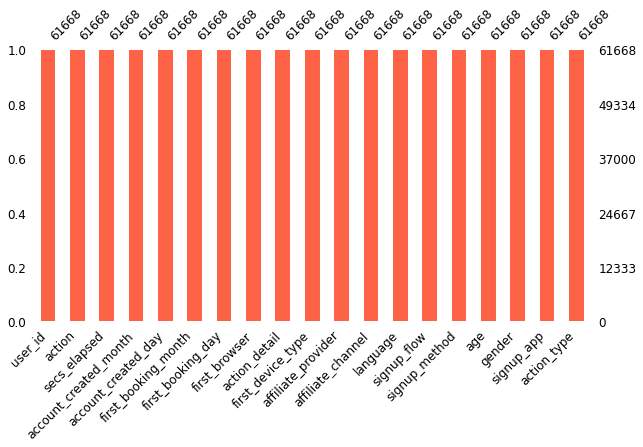

In [85]:
miss.bar(test, color="tomato", sort="ascending", figsize=(10,5), fontsize=12)

<font color = 'RED'>As a result, our test data has been cleaned, removing any NaNs, punctuation, outliers, etc. We can go on to next processes like engineering and encoding.

In [ ]:
# saving cleaned test data to disk

test.to_csv('final_test.csv',  index=False)

In [ ]:
test = pd.read_csv("/content/gdrive/MyDrive/Case_studies/final_test.csv")
print(test.shape)
test.head(5)

(61668, 19)


,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,account_created_day,account_created_month,first_booking_day,first_booking_month,action,action_type,action_detail,secs_elapsed
0,5uwns89zht,FEMALE,35.0,facebook,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,1,7,0.0,0.0,show show show personalize similar_listin...,message_post view view data data click ...,message_post p1 view_search_results wishli...,17903.000000
1,jtl0dijy2j,unknown,32.0,basic,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,1,7,0.0,0.0,authenticate ajax_refresh_subtotal similar_...,view click data view click click data ...,login_page change_trip_characteristics simi...,6113.600000
2,xx0ulgorjt,unknown,32.0,basic,0,en,direct,direct,Web,Windows_Desktop,Chrome,1,7,0.0,0.0,authenticate header_userpic personalize sh...,view data data view -unknown- -unknown- ...,login_page header_userpic wishlist_content_...,8526.178571
3,6c6puo6ix0,unknown,32.0,basic,0,en,direct,direct,Web,Windows_Desktop,IE,1,7,0.0,0.0,show index active collections show index...,view -unknown- -unknown- view view -unkn...,user_profile -unknown- -unknown- user_wish...,18624.491667
4,czqhjk3yfe,unknown,32.0,basic,0,en,direct,direct,Web,Mac_Desktop,Safari,1,7,0.0,0.0,active campaigns index index index listi...,-unknown- view view view view view -unk...,-unknown- view_search_results view_search_r...,53379.860759


In [ ]:
# reading cleaned Train data

train = pd.read_csv("/content/gdrive/MyDrive/Case_studies/final_train.csv")
print(train.shape)
train.head(5)

(73815, 20)


,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,account_created_day,account_created_month,first_booking_day,first_booking_month,action,action_type,action_detail,secs_elapsed
0,d1mm9tcy42,MALE,62.0,basic,0,en,sem_non_brand,google,Web,Windows_Desktop,Chrome,other,1,1,4.0,1.0,similar_listings_v2 show index personalize...,view view view data view click click c...,view_search_results p3 view_search_results ...,8972.365591
1,yo8nz8bqcq,unknown,32.0,basic,0,en,direct,direct,Web,Mac_Desktop,Firefox,NDF,1,1,0.0,0.0,identity jumio_token jumio_redirect identi...,-unknown- -unknown- -unknown- -unknown- d...,-unknown- -unknown- -unknown- -unknown- h...,206589.000000
2,4grx6yxeby,unknown,32.0,basic,0,en,sem_brand,google,Web,Windows_Desktop,Firefox,NDF,1,1,0.0,0.0,header_userpic confirm_email dashboard das...,data click view view submit,header_userpic confirm_email_link dashboard...,110738.800000
3,ncf87guaf0,unknown,32.0,basic,0,en,direct,direct,Web,Windows_Desktop,Chrome,NDF,1,1,0.0,0.0,ask_question confirm_email header_userpic ...,submit click data view message_post,contact_host confirm_email_link header_user...,300366.600000
4,4rvqpxoh3h,unknown,32.0,basic,25,en,direct,direct,iOS,iPhone,unknown,GB,1,1,2.0,1.0,ask_question header_userpic show confirm_e...,submit data message_post click view,contact_host header_userpic message_post c...,13428.400000


In [ ]:
train.shape

(73815, 20)

In [ ]:
y = train['country_destination'].values
X = train.drop(['country_destination'], axis=1)
X.head(1)

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,account_created_day,account_created_month,first_booking_day,first_booking_month,action,action_type,action_detail,secs_elapsed
0,d1mm9tcy42,MALE,62.0,basic,0,en,sem_non_brand,google,Web,Windows_Desktop,Chrome,1,1,4.0,1.0,similar_listings_v2 show index personalize...,view view view data view click click c...,view_search_results p3 view_search_results ...,8972.365591


In [ ]:
test.shape

(61668, 19)

In [ ]:
X.shape

(73815, 19)

### <font color = 'GREWWG'> ENCODING CATEGORICAL VARIABLES

#### <font color = 'GREEEN'>ENCODING SESSION DATA

In [ ]:
#tfidf vectorizer for 'action' column in Train and test data

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features = 1000)
vectorizer.fit(X['action'].values) 

X_action = vectorizer.transform(X['action'])

test_action = vectorizer.transform(test['action'])
test_action.shape

(61668, 1000)

In [ ]:
#tfidf vectorizer for 'action_type' column in Train and test data

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=1000)
vectorizer.fit(X['action_type'].values) 

X_action_type = vectorizer.transform(X['action_type'])

test_action_type = vectorizer.transform(test['action_type'])
test_action_type.shape

(61668, 1000)

In [ ]:
#tfidf vectorizer for 'action_detail' column in Train and test data

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=1000)
vectorizer.fit(X['action_detail'].values) 

X_action_detail = vectorizer.transform(X['action_detail'])

test_action_detail = vectorizer.transform(test['action_detail'])
test_action_type.shape

(61668, 1000)

In [ ]:
# BoW-vectorization for 'first_browser' column from Train and test data
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X['first_browser'].values)

X_first_browser = vectorizer.transform(X['first_browser'].values)

test_first_browser = vectorizer.transform(test['first_browser'].values)
test_first_browser.shape

(61668, 35)

In [ ]:
# BoW-vectorization for 'first_device_type' column from Train and test data

vectorizer = CountVectorizer()
vectorizer.fit(X['first_device_type'].values)

X_first_device_type = vectorizer.transform(X['first_device_type'].values)

test_first_device_type = vectorizer.transform(test['first_device_type'].values)
test_first_device_type.shape

(61668, 9)

In [ ]:
# BoW-vectorization for 'signup_app' column from Train and test data

vectorizer = CountVectorizer()
vectorizer.fit(X['signup_app'].values)

X_signup_app = vectorizer.transform(X['signup_app'].values)

test_signup_app = vectorizer.transform(test['signup_app'].values)
test_signup_app.shape

(61668, 4)

In [ ]:
# BoW-vectorization for 'affiliate_provider' column from Train and test data

vectorizer = CountVectorizer()
vectorizer.fit(X['affiliate_provider'].values)

X_affiliate_provider = vectorizer.transform(X['affiliate_provider'].values)

test_affiliate_provider = vectorizer.transform(test['affiliate_provider'].values)
test_affiliate_provider.shape

(61668, 17)

In [ ]:
# BoW-vectorization for 'affiliate_channel' column from Train and test data

vectorizer = CountVectorizer()
vectorizer.fit(X['affiliate_channel'].values)

X_affiliate_channel = vectorizer.transform(X['affiliate_channel'].values)

test_affiliate_channel = vectorizer.transform(test['affiliate_channel'].values)
test_affiliate_channel.shape

(61668, 8)

In [ ]:
# BoW-vectorization for 'language' column from Train and test data


vectorizer = CountVectorizer()
vectorizer.fit(X['language'].values)

X_language = vectorizer.transform(X['language'].values)

test_language = vectorizer.transform(test['language'].values)
test_language.shape

(61668, 24)

In [ ]:
# BoW-vectorization for 'signup_method' column from Train and test data

vectorizer = CountVectorizer()
vectorizer.fit(X['signup_method'].values)

X_signup_method = vectorizer.transform(X['signup_method'].values)

test_signup_method = vectorizer.transform(test['signup_method'].values)
test_signup_method.shape

(61668, 3)

In [ ]:
# BoW-vectorization for 'gender' column from Train and test data

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X['gender'].values)

X_gender = vectorizer.transform(X['gender'].values)

test_gender = vectorizer.transform(test['gender'].values)
test_gender.shape

(61668, 4)

### <font color = 'GREEEN'> STADARDIZING NUMERICAL FEATURES

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X['secs_elapsed'].values.reshape(-1,1))

X_secs = scaler.transform(X['secs_elapsed'].values.reshape(-1,1))
test_secs = scaler.transform(test['secs_elapsed'].values.reshape(-1,1))

In [ ]:
# reshaping numeric columns (from test data)
test_flow=test['signup_flow'].values.reshape(-1,1)
test_age=test['age'].values.reshape(-1,1)
test_book_day=test['first_booking_day'].values.reshape(-1,1)
test_book_month=test['first_booking_month'].values.reshape(-1,1)
test_create_month=test['account_created_month'].values.reshape(-1,1)
test_create_day=test['account_created_day'].values.reshape(-1,1)

In [ ]:
# reshaping numeric columns
X_flow=X['signup_flow'].values.reshape(-1,1)
X_age = X['age'].values.reshape(-1,1)
X_book_day=X['first_booking_day'].values.reshape(-1,1)
X_create_day=X['account_created_day'].values.reshape(-1,1)
X_book_month=X['first_booking_month'].values.reshape(-1,1)
X_create_month=X['account_created_month'].values.reshape(-1,1)

In [ ]:
# Oerforming label-encoding to convert textual-labels into numerical ones

from sklearn import preprocessing
 
label_encoder = preprocessing.LabelEncoder() 
y_tr= label_encoder.fit_transform(y)
y_tr=y_tr.reshape(-1,1)
print(y_tr.shape)
y_tr

(73815, 1)


array([[11],
       [ 7],
       [ 7],
       ...,
       [ 7],
       [ 7],
       [ 7]])

In [ ]:
# merging test encoded data, This test-data will be used to perform final test of the whole model of this Case Study

from scipy.sparse import hstack
final_test = hstack((test_signup_method, test_flow, test_age, test_gender, test_language,test_affiliate_provider,test_affiliate_channel,
              test_signup_app,test_first_browser,test_first_device_type,test_book_day,test_create_day,test_create_month,
              test_book_month,test_action_type,test_action,test_action_detail,test_secs)).tocsr()

print("Final Data matrix")
print(final_test.shape)

Final Data matrix
(61668, 3111)


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039

from scipy.sparse import hstack
X_tr = hstack((X_signup_app, X_age,X_gender, X_signup_method, X_flow, X_language,X_affiliate_channel,X_affiliate_provider,
              X_first_device_type,X_first_browser,X_create_day,X_create_month,X_book_day,
              X_book_month,X_action,X_action_detail,X_action_type,X_secs)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)

Final Data matrix
(73815, 3111) (73815, 1)


In [ ]:
import pickle
pickle.dump(final_test, open(r'test_CE.pkl', 'wb'))

In [ ]:
import pickle
final_test = pickle.load(open('/content/gdrive/MyDrive/Case_studies/test_CE.pkl', 'rb'))

In [ ]:
# Using NDCG score as our metric
# https://www.kaggle.com/davidgasquez/ndcg-scorer

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer
import numpy as np

def dcg_score(y_t, y_s, k=5):
    idx = np.argsort(y_s)[::-1]   # getting indices
    y_t = np.take(y_t, idx[:k])  # selective picking

    gain = 2 ** y_t - 1

    dsct = np.log2(np.arange(len(y_t)) + 2)
    return np.sum(gain / dsct)


#def ndcg_score(ground_truth, predictions, k=5):
def ndcg_score(test_l, pred, k):
    
    label = LabelBinarizer()
    label.fit(range(len(pred) + 1))
    trans = label.transform(test_l)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_t, y_s in zip(trans, pred):
        act = dcg_score(y_t, y_s, k)
        b = dcg_score(y_t, y_t, k)
        if b == 0:
            b = 0.000000001
        score = (float(act) / float(b))
        scores.append(score)
    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.15, random_state=42)

In [ ]:
pickle.dump([X_train, X_test, y_train, y_test], open('TT_split.pkl', 'wb'))

In [ ]:
X_train.shape

(62742, 3111)

### <font color = 'GREWWG'>MODEL TRAIN

In [ ]:
import pickle
X_train, X_test, y_train, y_test = pickle.load(open('/content/gdrive/MyDrive/Case_studies/TT_split.pkl', 'rb'))

### <font color = 'red'> KNN

In [ ]:
params = {'n_neighbors' : [11, 51, 81, 101, 121]}

clfcv = KNeighborsClassifier()
rcv = RandomizedSearchCV(clfcv, param_distributions = params, scoring = 'f1', cv=5, n_jobs = -1)
rcv.fit(X_train, y_train)

print('Best parameters:',rcv.best_params_)

Best parameters: {'n_neighbors': 51}


In [ ]:
knn = KNeighborsClassifier(n_neighbors = 51)
knn.fit(X_train,y_train)
prob_knn = knn.predict_proba(X_test)
score_knn = ndcg_score(y_test, prob_knn, k=5)
print(f"NDCG score : {score_knn} at K = 51")

NDCG score : 0.9297480285160814 at K = 51


### <font color = 'red'> NAIVE BAYES

In [ ]:
params = {'var_smoothing' : [10**x for x in range(-8,-2, 1)]}

clfcv = GaussianNB()
rcv = RandomizedSearchCV(clfcv, param_distributions = params, scoring = 'f1', cv=5, n_jobs = -1)
rcv.fit(X_train.toarray(), y_train)

print('Best parameters:',rcv.best_params_)

Best parameters: {'var_smoothing': 1e-08}


In [ ]:
nb = GaussianNB(var_smoothing = 1e-8)
nb.fit(X_train.toarray(),y_train)
prob_nb = nb.predict_proba(X_test.toarray())
score_nb = ndcg_score(y_test, prob_nb, k=5)
print(f"NDCG score : {score_nb}")

NDCG score : 0.36104965300150077


### <font color = 'red'> DECISION TREE

In [ ]:
params = {'max_depth' : [1, 2, 4, 5 ,6],
          'min_samples_split' : [5, 10, 20, 50, 100]}

clfcv = DecisionTreeClassifier()
rcv = RandomizedSearchCV(clfcv, param_distributions = params, scoring = 'f1', cv=5, n_jobs = -1)
rcv.fit(X_train, y_train)

print('Best parameters:',rcv.best_params_)

Best parameters: {'min_samples_split': 50, 'max_depth': 2}


In [ ]:
decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split= 50, max_depth=2 )
decision_tree.fit(X_train,y_train)
dt_prob = decision_tree.predict_proba(X_test)
score_dt = ndcg_score(y_test, dt_prob , k=5)
print (f"Depth of tree : 2 min_sample_split : 50, NDCG Score : {score_dt}")       

Depth of tree : 2 min_sample_split : 50, NDCG Score : 0.9357806858656479


### <font color = 'red'> LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
params = {'alpha' : [0.001, 0.01, 0.1, 1, 10, 100]}

clfcv = SGDClassifier()
rcv = RandomizedSearchCV(clfcv, param_distributions = params, scoring = 'f1', cv=5, n_jobs = -1)
rcv.fit(X_train, y_train)

print('Best parameters:',rcv.best_params_)

Best parameters: {'alpha': 0.001}


In [ ]:
sgd = SGDClassifier(class_weight='balanced', alpha = 0.001, penalty='l2', loss='log', random_state=42)
sgd.fit(X_train,y_train)
prob_sgd = sgd.predict_proba(X_test)
score_sgd = ndcg_score(y_test, prob_sgd, k = 5)
print(f"NDCG score = {score_sgd} at alpha = 0.001 ")

NDCG score = 0.8661561382556917 at alpha = 0.001 


### <font color = 'red'> XGBOOST

In [ ]:
# Hyper parameter tuning for the model

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

params = {'n_estimator' : [10, 50, 100, 500, 1000],
          'max_depth': [1, 2, 3, 4, 5]}

clfcv = XGBClassifier()
rcv = RandomizedSearchCV(clfcv, param_distributions = params, scoring = 'f1', cv=5, n_jobs = -1)
rcv.fit(X_train, y_train)

print('Best parameters:',rcv.best_params_)

Best parameters: {'n_estimator': 50, 'max_depth': 3}


In [ ]:
#Building the model 
from xgboost import XGBClassifier
     
xgb = XGBClassifier(max_depth=3, n_estimators=50, n_jobs = -1)
xgb.fit(X_train,y_train)  
prob_xgb = xgb.predict_proba(X_test)
score_xgb = ndcg_score(y_test, prob_xgb, k=5)

print ("Depth of tree : 3")
print ("Number of Estimators : 50")
print (f"NDCG Score : {score_xgb}")

Depth of tree : 3
Number of Estimators : 50
NDCG Score : 0.9362836989235902


### <font color = 'red'> RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

params = {'n_estimators' : [5, 10, 50, 100, 500],
          'max_depth': [1, 2, 3, 4, 6]}

clfcv = RandomForestClassifier()
rcv = RandomizedSearchCV(clfcv, param_distributions = params, scoring = 'f1', cv=5, n_jobs = -1)
rcv.fit(X_train, y_train)

print('Best parameters:',rcv.best_params_)

Best parameters: {'n_estimators': 500, 'max_depth': 4}


In [ ]:
clf_rf = RandomForestClassifier(n_estimators = 500 , criterion='gini', max_depth = 4, random_state=42, n_jobs=-1)
clf_rf.fit(X_train,y_train)
prob_rf = clf_rf.predict_proba(X_test)
score_rf = ndcg_score(y_test, prob_rf, k=5)
print (f"DT depth : 4 ")
print (f"Estimator NO. : 500 ")
print (f"NDCG Score : {score_rf}")
print("\n")

DT depth : 4 
Estimator NO. : 500 
NDCG Score : 0.8252035927367078




### <font color = 'red'> CUSTOM STACKING CLASSIFIER

In [ ]:
nb = GaussianNB(var_smoothing = 1e-8)
knn = KNeighborsClassifier(n_neighbors=51)
lr = LogisticRegression()
rf1 = RandomForestClassifier(n_estimators=50, max_depth=2)
rf2 = RandomForestClassifier(n_estimators=100, max_depth=3)
dt = DecisionTreeClassifier(max_depth = 2, min_samples_split = 50 )
xgb = XGBClassifier(max_depth=3, n_estimators=50, n_jobs = -1)
xgb2 = XGBClassifier(max_depth=3, n_estimators=50, n_jobs = -1)
baseline_models=[nb, knn, rf1, rf2, dt,  xgb, xgb2] 
metamodel = lr

In [ ]:
# Building custom stacking classifier
# spliting the training data into train(50) and test(50)
# Stacking the  D_train and D_test with target values
# Creating sample data sets from Data1
# Building custom stacking classifier
# Getting predictions from the stacked models

class Custom_SC():
    def __init__(self,val,estimators,metamodel):
        self.val = val 
        self.metamodel = metamodel
        self.estimators = estimators  
        
    def fit(self,x,y):
        #dividing the training data into the train(50) and test categories (50)
        self.x=x
        self.y=y
        Data_split1, Data_split2 , Data_split1_val, Data_split2_val = train_test_split(self.x , self.y , random_state=42, test_size=0.5)

        # combining the goal values from the D train and D test
        Data_split1_val = Data_split1_val.reshape(-1,1)
        Data_split2_val = Data_split2_val.reshape(-1,1)
        Stack_D1 = hstack((Data_split1, Data_split1_val))
        Stack_D2 = hstack((Data_split2, Data_split2_val))

        # Creating test data sets with Data1
        range = np.random.default_rng()
        sample_data = []
        for i in range(self.val):
            range_choice = range.choice(Stack_D1.toarray(),size=20000)
            sample_data.append(range_choice)

        # Generating a unique stacking classifier
        Stack_D2 = Stack_D2.toarray()
        Data_x = np.delete( Stack_D2, -1 , axis=1)
        Data_y = Stack_D2[:,-1]
        pred_1 = []

        for i in tqdm(range(len(self.estimators))):
            X_sample = np.delete(sample_data[i], -1 , axis=1)
            y_sample = sample_data[i][:,-1]
            
            self.estimators[i].fit(X_sample,y_sample)
            pred_2 = self.estimators[i].predict_proba(Data_x)
            pred_1.append(pred_2)
        final_pred = np.concatenate((pred_1),axis=1)
        self.meta = metamodel.fit(final_pred , Data_y)
    
    def proba_predict(self,X_test):
      # predicting using the stacked models
        pred = []
        for i in range(len(self.estimators)):
            pred_SC = self.estimators[i].predict_proba(X_test.toarray())
            pred.append(pred_SC)
        data = np.concatenate((pred),axis=1)
        pred_proba = self.meta.predict_proba(data)
        return pred_proba

In [ ]:
model = Custom_SC(7,baseline_models,metamodel)
model.fit(X_train, y_train)
p = model.proba_predict(X_test)

100%|██████████| 7/7 [23:32<00:00, 201.79s/it]


In [ ]:
NDCG_score = ndcg_score(y_test, p, k=5)
NDCG_score

0.9565077695856784

<font color = 'red'>With an **NDCG score of 0.9565**, our unique stacking classifier is producing encouraging results.</font>

### <font color = 'GREWWG'> SUMMERIZING MODEL PERFORMANCE

In [45]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ["Model", "NDCG Score"]
pt.add_row(['KNEAREST NEIGHBOUR',0.9297480285160814])
pt.add_row(['NAIVE BAYES',0.3610496530015007])
pt.add_row(['DECISION TREE',0.9357806858656479])
pt.add_row(['Logistic Regression',0.8661561382556917])
pt.add_row(['XGB Classifier',0.9362836989235902])
pt.add_row(['Random Forest Classifier',0.8252035927367078])
pt.add_row(['Custom Stacking Classifier',0.9565077695856784])
print(pt)

+----------------------------+--------------------+
|           Model            |     NDCG Score     |
+----------------------------+--------------------+
|     KNEAREST NEIGHBOUR     | 0.9297480285160814 |
|        NAIVE BAYES         | 0.3610496530015007 |
|       DECISION TREE        | 0.9357806858656479 |
|    Logistic Regression     | 0.8661561382556917 |
|       XGB Classifier       | 0.9362836989235902 |
|  Random Forest Classifier  | 0.8252035927367078 |
| Custom Stacking Classifier | 0.9565077695856784 |
+----------------------------+--------------------+


### <font color = 'GREWWG'>PREDICT TEST DATA

In [ ]:
import pickle
test = pickle.load(open('/content/gdrive/MyDrive/Case_studies/test_CE.pkl', 'rb'))

In [ ]:
# We utilise the stacking classifier model to generate predictions on the test data because it outperformed all other models in terms of accuracy.

model_pred = model.proba_predict(test) 
model_pred

array([[4.86525212e-06, 6.09852062e-06, 9.76608838e-06, ...,
        2.10557801e-06, 1.99618636e-05, 1.40737526e-05],
       [7.47511620e-06, 7.19165627e-06, 4.65809468e-06, ...,
        3.24317284e-06, 1.73748520e-05, 1.32825131e-05],
       [6.29389088e-06, 9.62025717e-06, 8.93380752e-06, ...,
        1.90732893e-06, 2.47957812e-05, 2.04842146e-05],
       ...,
       [4.16815109e-06, 5.00890517e-06, 4.50798824e-06, ...,
        1.68778523e-06, 1.18155359e-05, 9.29531421e-06],
       [6.35389278e-06, 9.69600170e-06, 9.08209727e-06, ...,
        1.91632928e-06, 2.48172363e-05, 2.03650749e-05],
       [4.94753426e-06, 6.18919413e-06, 9.99420951e-06, ...,
        2.13121196e-06, 2.01438229e-05, 1.41065372e-05]])

In [ ]:
model_pred.shape

(61668, 12)

<font color = 'RED'>This indicates that each user has 12 probabilities in the test data.

<font color = 'RED'>Simply put, this indicates that we receive probabilities (of course, varying between 0-1) of where a certain user is predicted to make his or her booking for each of the 12 class labels.

In [ ]:
model_pred[0]

array([4.86525212e-06, 6.09852062e-06, 9.76608838e-06, 1.60624061e-05,
       2.12764186e-05, 1.49542140e-05, 1.69510337e-05, 9.99860407e-01,
       1.34777362e-05, 2.10557801e-06, 1.99618636e-05, 1.40737526e-05])

In [ ]:
# In order to retrieve each user id and integrate it with the predictions we just produced above, we are reading this cleaned test data.
# This is due to the lack of user id in our forecasts.

final_test = pd.read_csv('/content/gdrive/MyDrive/Case_studies/final_test.csv')
final_test.head(1)

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,account_created_day,account_created_month,first_booking_day,first_booking_month,action,action_type,action_detail,secs_elapsed
0,5uwns89zht,FEMALE,35.0,facebook,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,1,7,0.0,0.0,show show show personalize similar_listin...,message_post view view data data click ...,message_post p1 view_search_results wishli...,17903.0


In [ ]:
final_test.shape

(61668, 19)

In [ ]:
user_id = final_test['user_id'].values

In [ ]:
# generating a dataframe of forecasts called "id proba," which stands for "probabilities per user id"

user_id_prob = pd.DataFrame(model_pred)
user_id_prob.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000005,0.000006,0.000010,0.000016,0.000021,0.000015,0.000017,0.999860,0.000013,0.000002,0.000020,0.000014
1,0.000007,0.000007,0.000005,0.000012,0.000024,0.000019,0.000016,0.999870,0.000006,0.000003,0.000017,0.000013
2,0.000006,0.000010,0.000009,0.000022,0.000025,0.000018,0.000019,0.999836,0.000009,0.000002,0.000025,0.000020


In [ ]:
# creating a new column with the value "user id"

user_id_prob['user_id'] = user_id 
user_id_prob.head()

,0,1,2,3,4,5,6,7,8,9,10,11,user_id
0,0.000005,0.000006,0.000010,0.000016,0.000021,0.000015,0.000017,0.999860,0.000013,0.000002,0.000020,0.000014,5uwns89zht
1,0.000007,0.000007,0.000005,0.000012,0.000024,0.000019,0.000016,0.999870,0.000006,0.000003,0.000017,0.000013,jtl0dijy2j
2,0.000006,0.000010,0.000009,0.000022,0.000025,0.000018,0.000019,0.999836,0.000009,0.000002,0.000025,0.000020,xx0ulgorjt
3,0.000007,0.000010,0.000010,0.000024,0.000026,0.000019,0.000018,0.999830,0.000010,0.000002,0.000025,0.000020,6c6puo6ix0
4,0.000006,0.000010,0.000009,0.000023,0.000025,0.000018,0.000018,0.999833,0.000010,0.000002,0.000025,0.000021,czqhjk3yfe


In [ ]:
user_id_prob.shape

(61668, 13)

In [ ]:
# Choosing the five classes with the best chances of success
 
test_uid = list(user_id_prob.user_id)
countries = []
user_ids = []

for i in range(len(test_uid)):
    index = test_uid[i]
    user_ids += [index] * 5
    countries += label_encoder.inverse_transform(np.argsort(model_pred[i])[::-1])[:5].tolist()

In [ ]:
#Generating final output file
final_output = pd.DataFrame(np.column_stack((user_ids , countries)), columns=['id', 'country'])
final_output.head(20)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,FR
2,5uwns89zht,US
3,5uwns89zht,IT
4,5uwns89zht,ES
5,jtl0dijy2j,NDF
6,jtl0dijy2j,FR
7,jtl0dijy2j,GB
8,jtl0dijy2j,US
9,jtl0dijy2j,IT


In [ ]:
final_output.to_csv('/content/gdrive/MyDrive/Case_studies/_final_output.csv',  index=False)

## <font color = 'BLUE'> CONCLUSION

<font color='red'>

1. Five destinations are being observed here against a user. These five locations are listed in the likelihood that each one will be visited order.

<font color='red'>

2. For instance, the person with the user id "5uwns89zht" has the highest likelihood of not making a reservation (NDF = no destination found = no reservation, which might indicate he visited the website likely to see or search something).

<font color='red'>

3. France, the United States, Italy, and Spain come next in our model. Therefore, if he plans to make a reservation, his top choices should be France, the US, Italy, and Spain.
</font>